# AMORE Project 
## Evaluation of the Automated Model Reduction (AMORE) Version 1.1 Isoprene Oxidation Mechanism in GEOS-Chem
## By Benjamin Yang

### Last updated: June 8, 2023

In [28]:
# Import modules
import os
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib import dates
from matplotlib.patches import Polygon
import re
import glob
from sklearn import metrics
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
mpl.rcParams['mathtext.default'] = 'regular' # no italics

In [39]:
# Get all dates between start and end dates inclusive
def date_range(start, end, delta):
    curr = start
    while curr <= end:
        yield curr
        curr += delta

# Create a directory (equivalent to using mkdir -p on the command line)
def mkdir_p(mypath):
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python > 2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

# Compute mean absolute error (MAE)
def get_mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

# Compute root mean squared error (RMSE)
def get_rmse(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.sqrt(((y_true - predictions) ** 2).mean())

# Compute normalized mean bias (NMB)
def get_nmb(y_true,predictions):  
    y_true, predictions = np.array(y_true), np.array(predictions)
    return ((predictions-y_true).sum()/y_true.sum())*100

# Get meteorological season based on month
def get_season(month):
    if (month == 12 or 1 <= month <= 2):
        return 'DJF'  # winter   
    elif (3 <= month <= 5):
        return 'MAM'  # spring
    elif (6 <= month <= 8):
        return 'JJA'  # summer
    else:
        return 'SON'  # fall

# Read latitude and longitude from file into numpy arrays
def naive_fast(latvar,lonvar,lat0,lon0):
    latvals = latvar[:]
    lonvals = lonvar[:]
    ny,nx = latvals.shape
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return int(iy_min),int(ix_min)  

# Calculate the average sensitivity of a variable to removing/adding emissions
def summer(sim1,sim2,sim3,sim4):
    v1 = all_df_new[(all_df_new['SEASON']=='JJA') & (all_df_new['variable']==sim1)]['value'] # BASE
    v2 = all_df_new[(all_df_new['SEASON']=='JJA') & (all_df_new['variable']==sim2)]['value'] # BASE_<zero_emissions>
    v3 = all_df_new[(all_df_new['SEASON']=='JJA') & (all_df_new['variable']==sim3)]['value'] # AMORE
    v4 = all_df_new[(all_df_new['SEASON']=='JJA') & (all_df_new['variable']==sim4)]['value'] # AMORE_<zero_emissions>
    c = np.mean([np.mean(np.array(v1)-np.array(v2)),np.mean(np.array(v3)-np.array(v4))]) # mean (AMORE/BASE) concentration difference
    p = np.mean([np.mean((np.array(v1)-np.array(v2))/np.array(v1)),np.mean((np.array(v3)-np.array(v4))/np.array(v3))])*100 # mean (AMORE/BASE) percent change
    return c,p

In [16]:
# Enter start and end dates
start = date(2018,1,1)
end = date(2018,12,31)

# Save all-inclusive dates to a list
alldates=[]
for result in date_range(start, end, relativedelta(months=1)):
    alldates.append(result.strftime('%Y%m'))
#alldates

In [17]:
# Define paths of data and figure directories
data_dir = '/data0/byang/amore_v4/' # AMORE
data_dir2 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA/' # BASE
data_dir3 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ISOP/' # BASE zUS_ISOP 
data_dir4 = '/data0/byang/amore_zUS_ISOP/' # AMORE zUS_ISOP 
data_dir5 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ANTH/' # BASE zUS_ANTH 
data_dir6 = '/data0/byang/amore_zUS_ANTH/' # AMORE zUS_ANTH 
data_dir7 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ISOP_ANTH/' # BASE zUS_ISOP_ANTH 
data_dir8 = '/data0/byang/amore_zUS_ISOP_ANTH/' # AMORE zUS_ISOP_ANTH 
data_dir9 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zGLB_ANTH/' # BASE zGLB_ANTH 
data_dir10 = '/data0/byang/amore_zGLB_ANTH/' # AMORE zGLB_ANTH 
data_dir11 = '/data0/byang/gc_geosfp_fullchem_complexSOA_SVPOA_US/' # BASE_HR
data_dir12 = '/data0/byang/amore_geosfp_highres/' # AMORE_HR
fig_dir = '/home/byang/output/amore/' # figures
obs_dir = '/home/byang/data/' # observational data
all_data_dir = [data_dir,data_dir2,data_dir3,data_dir4,data_dir5,data_dir6,data_dir7,data_dir8,data_dir9,data_dir10,data_dir11,data_dir12] # all 12 GEOS-Chem simulations

### Read and process AQS/IMPROVE observations

In [18]:
# Load AQS data from csv files
aqs_path = sorted(glob.glob(obs_dir+'AQS/*2018.csv'))
usecol = ['Latitude','Longitude','Parameter Name','Sample Duration','Date Local','Arithmetic Mean','Observation Percent']
aqs = []
for f in aqs_path:
    df = pd.read_csv(f,usecols=usecol)
    df = df[df['Arithmetic Mean']>=0] # remove negative values
    # Get lat/lon in SE US study area (bounding box values included by default)
    df = df[df['Latitude'].between(27,46) & df['Longitude'].between(-97,-69)] # remove buffer zone (3 deg)
    aqs.append(df)
    
# Combine data from different files into one dataframe 
aqs = pd.concat(aqs)
#aqs

In [19]:
# Load IMPROVE data from txt file
df = pd.read_csv(obs_dir+'AQS/improve_oc_2018.txt',delimiter='\s+')
df = df[df['OCf_Val']>=0] # remove negative values
# Get lat/lon in SE US study area (bounding box values included by default)
improve = df[df['Latitude'].between(27,46) & df['Longitude'].between(-97,-69)] # remove buffer zone (3 deg)
#improve

In [20]:
# Select, convert, and group variables
var_all = ['PM25','SpeciesConc_O3','SpeciesConc_NO','SpeciesConc_NO2','SpeciesConc_CH2O','SpeciesConc_ISOP','TotalOC']
obs_df = {}
for v in var_all:
    print(v)
    if v == 'PM25':
        var_obs = aqs[(aqs['Parameter Name']=='PM2.5 - Local Conditions')] # ug m-3
        var_obs = var_obs[var_obs['Sample Duration']!='1 HOUR'] # 24 HOUR or 24-HR BLK AVG only
    if v == 'SpeciesConc_O3':
        var_obs = aqs[aqs['Parameter Name']=='Ozone']
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean']*1e3 # ppm to ppb
    if v == 'SpeciesConc_NO':
        var_obs = aqs[aqs['Parameter Name']=='Nitric oxide (NO)'] # ppb
        var_obs = var_obs[var_obs['Observation Percent']==100]
        no_obs = var_obs
    if v == 'SpeciesConc_NO2': 
        var_obs = aqs[aqs['Parameter Name']=='Oxides of nitrogen (NOx)'] # NOx (ppb)
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Date Local'] = pd.to_datetime(var_obs['Date Local'])
        var_obs = pd.merge(var_obs,no_obs,on=['Latitude','Longitude','Date Local']) # combine NO and NOx dataframes
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean_x'] - var_obs['Arithmetic Mean_y'] # NO2 = NOx - NO
    if v == 'SpeciesConc_CH2O':
        var_obs = aqs[aqs['Parameter Name']=='Formaldehyde'] # ppb
        var_obs = var_obs[var_obs['Sample Duration']=='24 HOUR'] # excluding 8 HOUR
        var_obs = var_obs[var_obs['Observation Percent']==100]
    if v == 'SpeciesConc_ISOP':
        var_obs = aqs[aqs['Parameter Name']=='Isoprene'] 
        var_obs = var_obs[var_obs['Sample Duration']=='24 HOUR'] # excluding 1 HOUR and 3 HOURS
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean']/5 # ppbC to ppb
    if v == 'TotalOC':
        var_obs = improve # ug m-3
        var_obs = var_obs.rename(columns = {'Date':'Date Local','OCf_Val':'Arithmetic Mean'})
    var_obs['Date Local'] = pd.to_datetime(var_obs['Date Local'])
    var_obs = var_obs.groupby(['Latitude','Longitude',var_obs['Date Local'].dt.strftime('%Y%m')])['Arithmetic Mean'].mean().reset_index()
    obs_df[v] = var_obs
#obs_df['PM25']

PM25
SpeciesConc_O3
SpeciesConc_NO
SpeciesConc_NO2
SpeciesConc_CH2O
SpeciesConc_ISOP
TotalOC


### NOTE:  Must already have gridded OMI satellite air mass factors (AMFs) and scattering weights + derived/saved AMFs and vertical column densities (VCDs) of the GEOS-Chem model. If not, run "grid_amf_sw_swp.py" then "convert_gc_no2_hcho.py" before proceeding here.

In [21]:
# Read in saved data arrays from numpy files
vcd = np.load(fig_dir+'vcd.npy') # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
vcd_hr = np.load(fig_dir+'vcd_hr.npy') # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
amf = np.load(fig_dir+'amf.npy') # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
amf_hr = np.load(fig_dir+'amf_hr.npy') # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
amf_grid_all = np.load(fig_dir+'amf_grid_all.npy',allow_pickle=True) # month=12,species=2,lat=108/270,lon=144/360

### Regional (eastern US) comparisions: 12 GEOS-Chem model simulations vs. AQS/IMRPOVE/OMI obs

In [22]:
# Use the same variables defined above ("var_all")
var_label = ['$PM_{2.5}$ ($\mu$g $m^{-3}$)','$O_{3}$ (ppb)','NO (ppb)','$NO_{2}$ ($10^{15}$ molec $cm^{-2}$)','HCHO ($10^{15}$ molec $cm^{-2}$)','Isoprene (ppb)','Total OC ($\mu$g $m^{-3}$)']
vmin = [0,20,0,0,0,0,0] # lower limits for plotting variables
vmax = [10,40,0.5,5,15,2,2] # upper limits for plotting variables
vdiff_min = [-4,-20,-0.5,-5,-10,-3,-1] # lower limits for plotting variable differences
vdiff_max = [4,20,0.5,5,10,3,1] # upper limits for plotting variable differences
bmin = [0,0,0,0,0,0,0] # lower limits for box plots
bmax = [25,60,10,20,30,8,6] # upper limits for box plots
conv = [1,1e9,1e9,1e9,1e9,1e9,1] # unit conversion factors

In [23]:
# Loop over each variable and month
all_df = pd.DataFrame()
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
var_hr_df = pd.DataFrame()
var_hr_df2 = pd.DataFrame()
for i,v in enumerate(var_all):
    print(v)
    var_all_list = []
    var_mod_list = []
    var_mod_list2 = []
    var_hr_list = []
    var_hr_list2 = []
    
    # Create figure directory if does not exist
    mkdir_p(fig_dir+v)
    
    for di,d in enumerate(alldates):
        print(d)
        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            # Read in model output data
            if v[:7]=='Species':  
                n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
            elif v[:3]=='Rxn':
                n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
            else:
                n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d
            nc = Dataset(data_dir+n,'r') # AMORE
            nc12 = Dataset(data_dir12+n,'r') # AMORE_HR

            # Get model latitude & longitude
            if (v==var_all[3] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)
                lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
                lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES

            # Close the netCDF files
            nc.close()
            nc12.close()

            # Read in Aura-OMI obs
            if v=='SpeciesConc_NO2':
                # Get monthly Aura-OMI (satellite) tropospheric NO2 vertical column density (VCD) 
                nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_NO2_2018.nc','r')
                lat_no2 = nc0.variables['lat'][:] # 0.25 deg
                lon_no2 = nc0.variables['lon'][:] # 0.25 deg
                var_omi = nc0.variables['NO2'][di,:,:]/1e15 # 10^15 molec/cm^2
                #var_omi[(var_omi < 1) | (var_omi > 20)] = np.nan # filter out values beyond detection limits
                nc0.close()
                lat_omi = lat_no2
                lon_omi = lon_no2
                vi = 0 # NO2
            else:       
                # Get monthly Aura-OMI (satellite) tropospheric HCHO vertical column density (VCD) 
                nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_HCHO_2018.nc','r')
                lat_hcho = nc0.variables['lat'][:] # 0.1 deg
                lon_hcho = nc0.variables['lon'][:] # 0.1 deg
                var_omi = nc0.variables['HCHO'][di,:,:]/1e15 # 10^15 molec/cm^2
                #var_omi[(var_omi < 2.5) | (var_omi > 20)] = np.nan # filter out values beyond detection limits
                lat_omi = lat_hcho
                lon_omi = lon_hcho
                nc0.close()
                vi = 1 # HCHO

            # Extract relevant variables from converted model arrays
            var = vcd[di,vi,0,:,:]/1e15 # AMORE
            var2 = vcd[di,vi,1,:,:]/1e15 # BASE
            var3 = vcd[di,vi,2,:,:]/1e15 # BASE zUS_ISOP
            var4 = vcd[di,vi,3,:,:]/1e15 # AMORE zUS_ISOP
            var5 = vcd[di,vi,4,:,:]/1e15 # BASE zUS_ANTH
            var6 = vcd[di,vi,5,:,:]/1e15 # AMORE zUS_ANTH
            var7 = vcd[di,vi,6,:,:]/1e15 # BASE zUS_ISOP_ANTH
            var8 = vcd[di,vi,7,:,:]/1e15 # AMORE zUS_ISOP_ANTH
            var9 = vcd[di,vi,8,:,:]/1e15 # BASE zGLB_ANTH
            var10 = vcd[di,vi,9,:,:]/1e15 # AMORE zGLB_ANTH
            var11 = vcd_hr[di,vi,0,:,:]/1e15 # BASE_HR
            var12 = vcd_hr[di,vi,1,:,:]/1e15 # AMORE_HR

        else:
            # Get one month observations
            obs = obs_df[v][obs_df[v]['Date Local']==d].reset_index()
            var_1 = obs['Arithmetic Mean']
            lon_1 = obs['Longitude']
            lat_1 = obs['Latitude']

            # Read in model output data
            if v[:7]=='Species':  
                n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
            elif v[:3]=='Rxn':
                n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
            else:
                n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d   
            nc = Dataset(data_dir+n,'r') # AMORE
            nc2 = Dataset(data_dir2+n,'r') # BASE
            nc3 = Dataset(data_dir3+n,'r') # BASE zUS_ISOP
            nc4 = Dataset(data_dir4+n,'r') # AMORE zUS_ISOP
            nc5 = Dataset(data_dir5+n,'r') # BASE zUS_ANTH
            nc6 = Dataset(data_dir6+n,'r') # AMORE zUS_ANTH
            nc7 = Dataset(data_dir7+n,'r') # BASE zUS_ISOP_ANTH
            nc8 = Dataset(data_dir8+n,'r') # AMORE zUS_ISOP_ANTH
            nc9 = Dataset(data_dir9+n,'r') # BASE zGLB_ANTH
            nc10 = Dataset(data_dir10+n,'r') # AMORE zGLB_ANTH
            nc11 = Dataset(data_dir11+n,'r') # BASE_HR
            nc12 = Dataset(data_dir12+n,'r') # AMORE_HR

            # Extract relevant variables
            var = nc.variables[v][0,0,:,:]*conv[i] # AMORE
            var2 = nc2.variables[v][0,0,:,:]*conv[i] # BASE
            var3 = nc3.variables[v][0,0,:,:]*conv[i] # BASE zUS_ISOP
            var4 = nc4.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ISOP
            var5 = nc5.variables[v][0,0,:,:]*conv[i] # BASE zUS_ANTH
            var6 = nc6.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ANTH
            var7 = nc7.variables[v][0,0,:,:]*conv[i] # BASE zUS_ISOP_ANTH
            var8 = nc8.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ISOP_ANTH
            var9 = nc9.variables[v][0,0,:,:]*conv[i] # BASE zGLB_ANTH
            var10 = nc10.variables[v][0,0,:,:]*conv[i] # AMORE zGLB_ANTH
            var11 = nc11.variables[v][0,0,:,:]*conv[i] # BASE_HR
            var12 = nc12.variables[v][0,0,:,:]*conv[i] # AMORE_HR

            # Get model latitude & longitude
            if (v==var_all[0] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)
                lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
                lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES

            # Close the netCDF files
            nc.close()
            nc2.close()
            nc3.close()
            nc4.close()
            nc5.close()
            nc6.close()
            nc7.close()
            nc8.close()
            nc9.close()
            nc10.close()
            nc11.close()
            nc12.close()

        # Get monthly mean variables for each observational site or grid box 
        var_mod = []
        var_mod2 = []
        var_mod3 = []
        var_mod4 = []
        var_mod5 = []
        var_mod6 = []
        var_mod7 = []
        var_mod8 = []
        var_mod9 = []
        var_mod10 = []
        var_mod11 = []
        var_mod12 = []
        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            lat_1 = []
            lon_1 = []
            var_1 = []
            var_omi_new = [[np.nan for ilon in range(len(lon_omi))] for ilat in range(len(lat_omi))]
            for j in range(len(lat_omi)):
                for k in range(len(lon_omi)):
                    ix = np.argmin(np.abs(lat - lat_omi[j]))
                    iy = np.argmin(np.abs(lon - lon_omi[k]))
                    var_mod.append(var[ix,iy])
                    var_mod2.append(var2[ix,iy])
                    var_mod3.append(var3[ix,iy])
                    var_mod4.append(var4[ix,iy])
                    var_mod5.append(var5[ix,iy])
                    var_mod6.append(var6[ix,iy])
                    var_mod7.append(var7[ix,iy])
                    var_mod8.append(var8[ix,iy])
                    var_mod9.append(var9[ix,iy])
                    var_mod10.append(var10[ix,iy])
                    #var_omi_adjust = var_omi[j,k]*amf_grid_all[di,vi][ix,iy]/amf[di,vi,0,ix,iy] # use AMF of BASE
                    # HIGH-RES
                    ix = np.argmin(np.abs(lat_hr - lat_omi[j]))
                    iy = np.argmin(np.abs(lon_hr - lon_omi[k]))
                    var_mod11.append(var11[ix,iy])
                    var_mod12.append(var12[ix,iy])
                    
                    ###################################
                    #####  ADJUST SATELLITE DATA  #####
                    ###################################
                    # VCD_d' = (VCD_d * AMF_d) / (AMF_m)
                    var_omi_adjust = var_omi[j,k]*amf_grid_all[di,vi][ix,iy]/amf_hr[di,vi,0,ix,iy] # use AMF of BASE_HR
                    
                    # Filter out values beyond detection limits
                    if v=='SpeciesConc_NO2': # NO2 VCD
                        if (var_omi_adjust < 1 or var_omi_adjust > 20):
                            var_omi_adjust = np.nan
                    else: # HCHO VCD
                        if (var_omi_adjust < 2.5 or var_omi_adjust > 20):
                            var_omi_adjust = np.nan
                    
                    # Flatten 2D array to 1D for OMI obs 
                    lat_1.append(lat_omi[j])
                    lon_1.append(lon_omi[k])
                    var_1.append(var_omi_adjust)
                    var_omi_new[j][k] = var_omi_adjust
            lat_1 = np.array(lat_1)
            lon_1 = np.array(lon_1)
            var_1 = np.array(var_1)
        else:
            for j in range(len(lat_1)):
                ix = np.argmin(np.abs(lat - lat_1[j]))
                iy = np.argmin(np.abs(lon - lon_1[j]))
                var_mod.append(var[ix,iy])
                var_mod2.append(var2[ix,iy])
                var_mod3.append(var3[ix,iy])
                var_mod4.append(var4[ix,iy])
                var_mod5.append(var5[ix,iy])
                var_mod6.append(var6[ix,iy])
                var_mod7.append(var7[ix,iy])
                var_mod8.append(var8[ix,iy])
                var_mod9.append(var9[ix,iy])
                var_mod10.append(var10[ix,iy])
                # HIGH-RES
                ix = np.argmin(np.abs(lat_hr - lat_1[j]))
                iy = np.argmin(np.abs(lon_hr - lon_1[j]))
                var_mod11.append(var11[ix,iy])
                var_mod12.append(var12[ix,iy])
        
        # Create dataframe with all information at each observational site or grid box
        df = pd.DataFrame({'LAT':np.array(lat_1),'LON':np.array(lon_1),'AQS':np.array(var_1),'AMORE':np.array(var_mod),'BASE':np.array(var_mod2),
                           'BASE_zUS_ISOP':np.array(var_mod3),'AMORE_zUS_ISOP':np.array(var_mod4),'BASE_zUS_ANTH':np.array(var_mod5),
                           'AMORE_zUS_ANTH':np.array(var_mod6),'BASE_zUS_ISOP_ANTH':np.array(var_mod7),'AMORE_zUS_ISOP_ANTH':np.array(var_mod8),
                           'BASE_zGLB_ANTH':np.array(var_mod9),'AMORE_zGLB_ANTH':np.array(var_mod10),'BASE_HR':np.array(var_mod11),'AMORE_HR':np.array(var_mod12),
                           'DIFF':np.array(var_mod-var_1),'DIFF2':np.array(var_mod2-var_1),'DIFF3':np.array(var_mod12-var_1),'DIFF4':np.array(var_mod11-var_1),
                           'MONTH':datetime.strptime(d,'%Y%m').month,'SEASON':get_season(datetime.strptime(d,'%Y%m').month)})
        var_all_list.append(df)
        var_mod_list.append(var) # AMORE
        var_mod_list2.append(var2) # BASE
        var_hr_list.append(var12) # High-res AMORE! 
        var_hr_list2.append(var11) # High-res BASE!

        # Compute difference (model-obs)
        var_diff = var_mod - var_1
        var_diff2 = var_mod2 - var_1
        var_range = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(var_diff),np.nanmax(var_diff),np.nanmean(var_diff))
        var_range2 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(var_diff2),np.nanmax(var_diff2),np.nanmean(var_diff2))

        # Create montly map of obs vs. AMORE
        fig1,ax1 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
            x_1, y_1 = m(list(lon_1.astype(float)),list(lat_1.astype(float))) # AQS
            sc = m.scatter(x_1,y_1,s=40,c=var_1,vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('AMORE GEOS-Chem vs. AQS obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig1.tight_layout()
        fig1.savefig(fig_dir+'%s/us_map_AMORE_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()

        # Create monthly map of obs vs. BASE
        fig2,ax2 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
            x_1, y_1 = m(list(lon_1.astype(float)),list(lat_1.astype(float))) # AQS
            sc = m.scatter(x_1,y_1,s=40,c=var_1,vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('BASE GEOS-Chem vs. AQS obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig2.tight_layout()
        fig2.savefig(fig_dir+'%s/us_map_BASE_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()

        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            # Create monthly map of OMI obs
            fig3,ax3 = plt.subplots(figsize=(12,8))
            m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
            x, y = m(*np.meshgrid(lon_omi,lat_omi)) # model
            m.pcolormesh(x,y,var_omi_new,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
            m.drawcoastlines()
            m.drawmapboundary()
            m.drawcountries()
            cb = m.colorbar(location='bottom',pad=0.6,extend='max')
            cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
            cb.ax.tick_params(labelsize=16)
            plt.title('Aura-OMI obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
            fig3.tight_layout()
            fig3.savefig(fig_dir+'%s/us_map_OMI_%s.png'%(v,d),dpi=300,bbox_inches='tight')
            plt.close()

    # Append to dataframes
    all_df[v] = var_all_list
    var_df[v] = var_mod_list
    var_df2[v] = var_mod_list2
    var_hr_df[v] = var_hr_list
    var_hr_df2[v] = var_hr_list2

PM25
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_O3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO2
201801


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:201: UserWarning: Warning: converting a masked element to nan.
/home/byang/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_CH2O
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_ISOP
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalOC
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812


In [40]:
# Loop over each variable averaged over the entire year (or by season)
r_amore = []
r_amore_hr = []
r_base = []
r_base_hr = []
nmb_amore = []
nmb_amore_hr = []
nmb_base = []
nmb_base_hr = []
palette = ['#9E9E9E','#1976D2','#90CAF9','#388E3C','#A5D6A7','#D32F2F','#EF9A9A','#FFA000','#FFE082','#7B1FA2','#CE93D8','#0097A7','#80DEEA'] # custom color palette
for i,v in enumerate(var_all):
    print(v)
    var_avg = np.mean(var_df[v])
    var_avg2 = np.mean(var_df2[v])
    var_hr_avg = np.mean(var_hr_df[v])
    var_hr_avg2 = np.mean(var_hr_df2[v])
    
    # Compute annual average at each observation point
    vavg = pd.concat(np.array(all_df[v])).groupby(['LAT','LON'],sort=False,as_index=False).mean()
    # Percent Bias = (model-obs)/obs*100
    #var_range = 'Bias:  Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.nanmin(vavg['DIFF']/vavg['AQS']*100),np.nanmax(vavg['DIFF']/vavg['AQS']*100),np.nanmean(vavg['DIFF']/vavg['AQS']*100))
    #var_range2 = 'Bias:  Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.nanmin(vavg['DIFF2']/vavg['AQS']*100),np.nanmax(vavg['DIFF2']/vavg['AQS']*100),np.nanmean(vavg['DIFF2']/vavg['AQS']*100))
    #var_range3 = 'Bias:  Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.nanmin(vavg['DIFF3']/vavg['AQS']*100),np.nanmax(vavg['DIFF3']/vavg['AQS']*100),np.nanmean(vavg['DIFF3']/vavg['AQS']*100))
    #var_range4 = 'Bias:  Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.nanmin(vavg['DIFF4']/vavg['AQS']*100),np.nanmax(vavg['DIFF4']/vavg['AQS']*100),np.nanmean(vavg['DIFF4']/vavg['AQS']*100))
    var_range = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF']),np.nanmax(vavg['DIFF']),np.nanmean(vavg['DIFF']))
    var_range2 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF2']),np.nanmax(vavg['DIFF2']),np.nanmean(vavg['DIFF2']))
    var_range3 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF3']),np.nanmax(vavg['DIFF3']),np.nanmean(vavg['DIFF3']))
    var_range4 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF4']),np.nanmax(vavg['DIFF4']),np.nanmean(vavg['DIFF4']))

    # Create annual map of obs vs. AMORE
    fig1,ax1 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon,lat)) # model
    m.pcolormesh(x,y,var_avg,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('AMORE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
    elif v=='TotalOC':
        plt.title('AMORE GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
    else:
        plt.title('AMORE GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
    fig1.tight_layout()
    fig1.savefig(fig_dir+'%s/us_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of obs vs. BASE
    fig2,ax2 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon,lat)) # model
    m.pcolormesh(x,y,var_avg2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
    elif v=='TotalOC':
        plt.title('BASE GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
    else:
        plt.title('BASE GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
    fig2.tight_layout()
    fig2.savefig(fig_dir+'%s/us_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of AMORE bias
    fig3,ax3 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    if v=='SpeciesConc_NO2':
        x, y = m(*np.meshgrid(lon_no2,lat_no2)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF3']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('AMORE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='SpeciesConc_CH2O':
        x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF3']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('AMORE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['DIFF']),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i],edgecolors='k',linewidths=0.1) # AQS
        plt.title('AMORE GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=14,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    fig3.tight_layout()
    fig3.savefig(fig_dir+'%s/us_bias_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of BASE bias
    fig4,ax4 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
    if v=='SpeciesConc_NO2':
        x, y = m(*np.meshgrid(lon_no2,lat_no2)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF4']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('BASE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='SpeciesConc_CH2O':
        x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF4']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('BASE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['DIFF2']),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i],edgecolors='k',linewidths=0.1) # AQS
        plt.title('BASE GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=14,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    fig4.tight_layout()
    fig4.savefig(fig_dir+'%s/us_bias_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create scatter plot of obs vs. AMORE
    fig5,ax5 = plt.subplots(figsize=(7,6))
    valid = np.isfinite(vavg['AQS']) # excluding 'nan'
    stat = stats.linregress(vavg['AQS'][valid],vavg['AMORE'][valid])
    stat_hr = stats.linregress(vavg['AQS'][valid],vavg['AMORE_HR'][valid])
    r2 = stat.rvalue**2 # coefficient of determination
    r_amore.append(stat.rvalue) # correlation coefficient
    r_amore_hr.append(stat_hr.rvalue) # correlation coefficient
    nmb = get_nmb(vavg['AQS'][valid],vavg['AMORE'][valid])
    nmb_hr = get_nmb(vavg['AQS'][valid],vavg['AMORE_HR'][valid])
    nmb_amore.append(nmb)
    nmb_amore_hr.append(nmb_hr)
    ax5.scatter(vavg['AQS'][valid],vavg['AMORE'][valid],s=20)
    smin = round(np.min([vavg['AQS'][valid],vavg['AMORE'][valid]]))
    smax = round(np.max([vavg['AQS'][valid],vavg['AMORE'][valid]]))
    xticks = np.arange(smin,smax*1.05)
    ax5.plot(xticks,stat.intercept+(stat.slope*xticks),'k--')
    ax5.set_xlabel('Observed '+var_label[i], fontsize=16, labelpad=10)
    ax5.set_ylabel('Predicted '+var_label[i], fontsize=16, labelpad=15)
    ax5.tick_params(axis='both', which='major', labelsize=14)
    ax5.set_xlim([smin,smax])
    ax5.set_ylim([smin,smax])
    ax5.annotate('$R^{2}$ = %.2f'%r2,xy=(0.75,0.22),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax5.annotate('NMB = %.2f'%nmb,xy=(0.75,0.15),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax5.annotate('N = %i'%len(vavg),xy=(0.75,0.08),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    plt.title('AMORE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=10,fontweight='bold')
    fig5.tight_layout()
    fig5.savefig(fig_dir+'%s/us_scatter_plot_AMORE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create scatter plot of obs vs. BASE
    fig6,ax6 = plt.subplots(figsize=(7,6))
    stat = stats.linregress(vavg['AQS'][valid],vavg['BASE'][valid])
    stat_hr = stats.linregress(vavg['AQS'][valid],vavg['BASE_HR'][valid])
    r2 = stat.rvalue**2 # coefficient of determination
    r_base.append(stat.rvalue) # correlation coefficient
    r_base_hr.append(stat_hr.rvalue) # correlation coefficient
    nmb = get_nmb(vavg['AQS'][valid],vavg['BASE'][valid])
    nmb_hr = get_nmb(vavg['AQS'][valid],vavg['BASE_HR'][valid])
    nmb_base.append(nmb)
    nmb_base_hr.append(nmb_hr)
    ax6.scatter(vavg['AQS'][valid],vavg['BASE'][valid],s=20)
    smin = round(np.min([vavg['AQS'][valid],vavg['BASE'][valid]]))
    smax = round(np.max([vavg['AQS'][valid],vavg['BASE'][valid]]))
    xticks = np.arange(smin,smax*1.05)
    ax6.plot(xticks,stat.intercept+(stat.slope*xticks),'k--')
    ax6.set_xlabel('Observed '+var_label[i], fontsize=16, labelpad=10)
    ax6.set_ylabel('Predicted '+var_label[i], fontsize=16, labelpad=15)
    ax6.tick_params(axis='both', which='major', labelsize=14)
    ax6.set_xlim([smin,smax])
    ax6.set_ylim([smin,smax])
    ax6.annotate('$R^{2}$ = %.2f'%r2,xy=(0.75,0.22),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax6.annotate('NMB = %.2f'%nmb,xy=(0.75,0.15),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax6.annotate('N = %i'%len(vavg),xy=(0.75,0.08),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    plt.title('BASE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=10,fontweight='bold')
    fig6.tight_layout()
    fig6.savefig(fig_dir+'%s/us_scatter_plot_BASE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create box plots of seasonal AQS, AMORE, BASE, & zUS_ISOP 
    all_df_new = pd.concat(list(all_df[v]))[['SEASON','AQS','BASE','AMORE','BASE_HR','AMORE_HR','BASE_zUS_ISOP','AMORE_zUS_ISOP','BASE_zUS_ANTH','AMORE_zUS_ANTH',
                                             'BASE_zUS_ISOP_ANTH','AMORE_zUS_ISOP_ANTH','BASE_zGLB_ANTH','AMORE_zGLB_ANTH']]
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        all_df_new = all_df_new.rename(columns={'AQS':'OMI'})
    if v=='TotalOC':
        all_df_new = all_df_new.rename(columns={'AQS':'IMRPROVE'})
    fig7,ax7 = plt.subplots(figsize=(14,5))
    ax7 = sns.boxplot(x='SEASON',y='value',hue='variable',data=all_df_new.melt(id_vars='SEASON'),palette=sns.color_palette(palette,13)) # or 'Paired'
    ax7.legend_.set_title(None)
    sns.move_legend(ax7,'center right',bbox_to_anchor=(1.25, 0.5))
    ax7.set_xlabel('Season', fontsize=16, labelpad=15)
    ax7.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    ax7.set_ylim([bmin[i],bmax[i]])
    ax7.tick_params(axis='both', which='major', labelsize=14)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('Seasonal Distributions over Eastern U.S. Aura-OMI Grid 2018',fontsize=16,pad=15,fontweight='bold')
    elif v=='TotalOC':
        plt.title('Seasonal Distributions at Eastern U.S. IMPROVE Sites 2018',fontsize=16,pad=15,fontweight='bold')
    else:
        plt.title('Seasonal Distributions at Eastern U.S. AQS Sites 2018',fontsize=16,pad=15,fontweight='bold')
    fig7.tight_layout()
    fig7.savefig(fig_dir+'%s/us_box_plot_all.png'%v,dpi=300,bbox_inches='tight')
    plt.close()

    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        # Create annual map of OMI obs
        fig8,ax8 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        if v=='SpeciesConc_NO2':
            x, y = m(*np.meshgrid(lon_no2,lat_no2)) # model
        else:
            x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # model
        m.pcolormesh(x,y,np.array(vavg['AQS']).reshape(x.shape),cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('Aura-OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
        fig8.tight_layout()
        fig8.savefig(fig_dir+'%s/us_map_OMI.png'%v,dpi=300,bbox_inches='tight')
        plt.close()
    
    # Create annual map of obs vs. AMORE HIGH-RES
    fig9,ax9 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr)) # model
    m.pcolormesh(x,y,var_hr_avg,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('AMORE_HR GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
    elif v=='TotalOC':
        plt.title('AMORE_HR GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range3,fontsize=16,labelpad=-70)
    else:
        plt.title('AMORE_HR GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range3,fontsize=16,labelpad=-70)
    fig9.tight_layout()
    fig9.savefig(fig_dir+'%s/us_map_AMORE_HR.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of obs vs. BASE HIGH-RES
    fig10,ax10 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr)) # model
    m.pcolormesh(x,y,var_hr_avg2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('BASE_HR GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
    elif v=='TotalOC':
        plt.title('BASE_HR GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range4,fontsize=16,labelpad=-70)
    else:
        plt.title('BASE_HR GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range4,fontsize=16,labelpad=-70)
    fig10.tight_layout()
    fig10.savefig(fig_dir+'%s/us_map_BASE_HR.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create box plots of SUMMERTIME AQS, AMORE, BASE, & zUS_ISOP 
    all_df_new = pd.concat(list(all_df[v]))[['SEASON','AQS','BASE','AMORE','BASE_HR','AMORE_HR','BASE_zUS_ISOP','AMORE_zUS_ISOP','BASE_zUS_ANTH','AMORE_zUS_ANTH',
                                             'BASE_zUS_ISOP_ANTH','AMORE_zUS_ISOP_ANTH','BASE_zGLB_ANTH','AMORE_zGLB_ANTH']]
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        all_df_new = all_df_new.rename(columns={'AQS':'OMI'})
    if v=='TotalOC':
        all_df_new = all_df_new.rename(columns={'AQS':'IMRPROVE'})
    all_df_new = all_df_new.melt(id_vars='SEASON')
    fig11,ax11 = plt.subplots(figsize=(9,6))
    ax11 = sns.boxplot(x='variable',y='value',data=all_df_new[all_df_new['SEASON']=='JJA'],palette=sns.color_palette(palette,13)) # or 'Paired'
    ax11.set_xlabel('')
    ax11.set_xticklabels(all_df_new['variable'].unique(),rotation=45, ha='right')
    ax11.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    ax11.set_ylim([bmin[i],bmax[i]])
    ax11.tick_params(axis='both', which='major', labelsize=14)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('Summer 2018 Distributions over Eastern U.S. Aura-OMI Grid',fontsize=16,pad=15,fontweight='bold')
    elif v=='TotalOC':
        plt.title('Summer 2018 Distributions at Eastern U.S. IMPROVE Sites',fontsize=16,pad=15,fontweight='bold')
    else:
        plt.title('Summer 2018 Distributions at Eastern U.S. AQS Sites',fontsize=16,pad=15,fontweight='bold')
    fig11.tight_layout()
    fig11.savefig(fig_dir+'%s/us_box_plot_summer.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Display the average sensitivity of a variable to removing/adding emissions
    print('- sensitivity - ')
    print('US ISOP: %.1f (%.0f%%)'%summer('BASE','BASE_zUS_ISOP','AMORE','AMORE_zUS_ISOP'))
    print('US ANTH: %.1f (%.0f%%)'%summer('BASE','BASE_zUS_ANTH','AMORE','AMORE_zUS_ANTH'))
    print('US ISOP+ANTH: %.1f (%.0f%%)'%summer('BASE','BASE_zUS_ISOP_ANTH','AMORE','AMORE_zUS_ISOP_ANTH'))
    print('GLB ANTH: %.1f (%.0f%%)'%summer('BASE','BASE_zGLB_ANTH','AMORE','AMORE_zGLB_ANTH'))
    
    # Calculate the T-test for the means of two independent samples of scores
    t_stat,p_val = ttest_ind(var_avg.flatten(),var_avg2.flatten())
    t_stat2,p_val2 = ttest_ind(var_hr_avg.flatten(),var_hr_avg2.flatten())
    print('- t-test - ')
    print('AMORE vs. BASE p-value = %.3f'%p_val)
    print('AMORE_HR vs. BASE_HR p-value = %.3f'%p_val2)

PM25
- sensitivity - 
US ISOP: 0.7 (9%)
US ANTH: 3.4 (45%)
US ISOP+ANTH: 3.9 (51%)
GLB ANTH: 3.6 (47%)
- t-test - 
AMORE vs. BASE p-value = 0.912
AMORE_HR vs. BASE_HR p-value = 0.018
SpeciesConc_O3
- sensitivity - 
US ISOP: 1.8 (4%)
US ANTH: 21.2 (47%)
US ISOP+ANTH: 18.7 (42%)
GLB ANTH: 23.1 (52%)
- t-test - 
AMORE vs. BASE p-value = 0.003
AMORE_HR vs. BASE_HR p-value = 0.053
SpeciesConc_NO
- sensitivity - 
US ISOP: -0.0 (-17%)
US ANTH: 0.1 (84%)
US ISOP+ANTH: 0.1 (80%)
GLB ANTH: 0.1 (84%)
- t-test - 
AMORE vs. BASE p-value = 0.945
AMORE_HR vs. BASE_HR p-value = 0.888
SpeciesConc_NO2
- sensitivity - 
US ISOP: -0.1 (-4%)
US ANTH: 0.9 (34%)
US ISOP+ANTH: 0.8 (31%)
GLB ANTH: 0.9 (34%)
- t-test - 
AMORE vs. BASE p-value = 0.682
AMORE_HR vs. BASE_HR p-value = 0.726
SpeciesConc_CH2O
- sensitivity - 
US ISOP: 3.0 (23%)
US ANTH: 1.6 (15%)
US ISOP+ANTH: 4.1 (34%)
GLB ANTH: 1.7 (15%)
- t-test - 
AMORE vs. BASE p-value = 0.007
AMORE_HR vs. BASE_HR p-value = 0.000
SpeciesConc_ISOP
- sensitivity - 

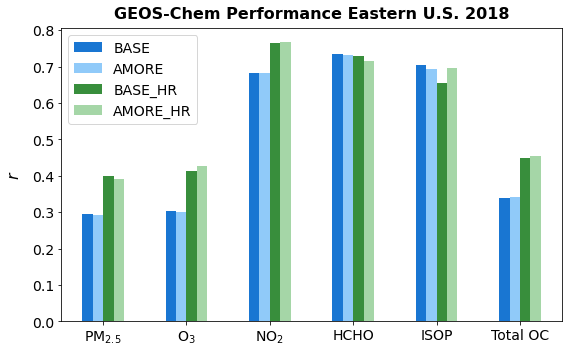

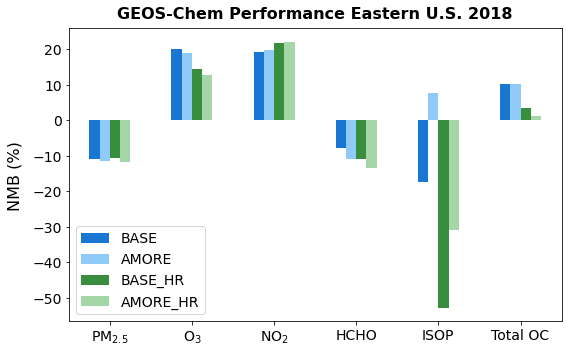

In [41]:
# Create bar charts with model performance statistics for BASE, AMORE, BASE_HR, and AMORE_HR, grouped by variable
palette = ['#1976D2','#90CAF9','#388E3C','#A5D6A7']
var_label2 = ['$PM_{2.5}$','$O_{3}$','NO','$NO_{2}$','HCHO','ISOP','Total OC']

# Pearson's correlation coefficient (r)
r_df = pd.DataFrame({'BASE':r_base,'AMORE':r_amore,'BASE_HR':r_base_hr,'AMORE_HR':r_amore_hr},index=var_label2)
fig12,ax12=plt.subplots(figsize=(8,5))
r_df.drop('NO').plot.bar(ax=ax12,rot=0,color=palette)                 
ax12.set_ylabel('$\it{r}$',fontsize='16',labelpad=10)
ax12.tick_params(axis='both', labelsize=14)
ax12.legend(loc='upper left',fontsize=14)
ax12.set_title('GEOS-Chem Performance Eastern U.S. 2018',fontsize='16',pad=10,fontweight='bold')
fig12.tight_layout()
fig12.savefig(fig_dir+'all_r.png',dpi=300,bbox_inches='tight')

# Normalized mean bias (NMB)
nmb_df = pd.DataFrame({'BASE':nmb_base,'AMORE':nmb_amore,'BASE_HR':nmb_base_hr,'AMORE_HR':nmb_amore_hr},index=var_label2)
fig13,ax13=plt.subplots(figsize=(8,5))
nmb_df.drop('NO').plot.bar(ax=ax13,rot=0,color=palette)                 
ax13.set_ylabel('NMB (%)',fontsize='16',labelpad=10)
ax13.tick_params(axis='both', labelsize=14)
ax13.legend(loc='lower left',fontsize=14)
ax13.set_title('GEOS-Chem Performance Eastern U.S. 2018',fontsize='16',pad=10,fontweight='bold')
fig13.tight_layout()
fig13.savefig(fig_dir+'all_nmb.png',dpi=300,bbox_inches='tight')

### GEOS-Chem monthly wall-clock times: test statistical significance (AMORE vs. BASE, AMORE_HR vs. BASE_HR) 

In [42]:
# Monthly run times (seconds): t1/t5/t9 = BASE, t2/t6/t10 = AMORE, t3/t7/t11 = BASE_HR, t4/t8/t12 = AMORE_HR
# These numbers were copied from the monthly GEOS-Chem log files 
# "GEOS-Chem" (total) timer:
t1 = [53331.281,47940,54141.883,52320.82,53594.406,51660,53426.809,53802.047,53004.875,54060,51439.594,52551.789]
t2 = [50007.062,44700,50008.979,48225.961,49458.273,47820,49624.535,49856.18,48812.859,49920,47611.289,48700.859]
t3 = [159120,147240.168,153060,145260,151898.443,151320,153960,155086.941,148980,152460,145537.82,150915.9]
t4 = [158100,135180,157150.855,143340,150780,146771.098,151980,151680,146520,149220,143263.826,144300]
# "All chemistry" timer:
t5 = [20470.281,18758.606,22034.438,20784.797,20839.297,20035.812,21114.391,21495.836,21706.031,21637.95,20001.527,20284.25]
t6 = [17388.031,15971.465,18617.54,17752.754,17719.844,17139.648,17997.84,18293.562,18316.484,18309.923,17011.439,17244.578]
t7 = [23907.41,21282.618,24147.25,23430.686,25143.264,25419.08,26654.165,26826.367,25038.921,25077.209,22786.27,23732.928]
t8 = [22264.782,18694.862,21642.246,21250.431,22930.991,22966.25,24619.579,24419.161,22847.005,22464.188,20557.572,21111.769]
# "KPP" timer:
t9 = [12754.314,12004.491,14248.398,13252.849,13140.012,12532.649,13237.618,13627.277,14010.493,13880.397,12687.734,12741.999]
t10 = [9629.08,9055.013,10685.269,9993.092,9928.29,9510.225,10001.566,10297.435,10528.454,10441.84,9567.49,9582.329]
t11 = [12913.072,11710.194,13317.786,12846.21,14256.094,14167.705,14785.365,14939.46,13851.494,13533.088,12686.411,12930.858]
t12 = [10106.056,9109.28,10414.844,10104.726,11645.657,11642.322,12124.067,12281.408,11320.82,10743.832,9925.364,9965.663]

In [43]:
# Calculate the T-test for the means of two independent samples of scores
t_stat3,p_val3 = ttest_ind(t1,t2)
t_stat4,p_val4 = ttest_ind(t3,t4)
t_stat5,p_val5 = ttest_ind(t5,t6)
t_stat6,p_val6 = ttest_ind(t7,t8)
t_stat7,p_val7 = ttest_ind(t9,t10)
t_stat8,p_val8 = ttest_ind(t11,t12)
print('- GEOS-Chem (total) -')
print('AMORE vs. BASE p_value = %.3f'%p_val3)
print('AMORE_HR vs. BASE_HR p_value = %.3f'%p_val4)
print('- all chemistry -')
print('AMORE vs. BASE p_value = %.3f'%p_val5)
print('AMORE_HR vs. BASE_HR p_value = %.3f'%p_val6)
print('- KPP -')
print('AMORE vs. BASE p_value = %.3f'%p_val7)
print('AMORE_HR vs. BASE_HR p_value = %.3f'%p_val8)

- GEOS-Chem (total) -
AMORE vs. BASE p_value = 0.000
AMORE_HR vs. BASE_HR p_value = 0.177
- all chemistry -
AMORE vs. BASE p_value = 0.000
AMORE_HR vs. BASE_HR p_value = 0.002
- KPP -
AMORE vs. BASE p_value = 0.000
AMORE_HR vs. BASE_HR p_value = 0.000


### Global model output: AMORE vs. BASE species

In [44]:
# Define new variables
var_all = ['PM25','TotalOC','TotalBiogenicOA','AerMassSOAIE','SpeciesConc_ISOP','SpeciesConc_O3','SpeciesConc_OH','SpeciesConc_NO','SpeciesConc_NO2','SpeciesConc_NO3','SpeciesConc_HO2','SpeciesConc_CH2O','SpeciesConc_IDN','SpeciesConc_IHOO1','SpeciesConc_IDCHP','SpeciesConc_ICN','SpeciesConc_INPB','SpeciesConc_IHN1','SpeciesConc_IDC','SpeciesConc_IEPOXA']
var_label = ['$PM_{2.5}$ ($\mu$g $m^{-3}$)','Total OC ($\mu$g $m^{-3}$)','Biogenic OA ($\mu$g $m^{-3}$)','Aerosol-Phase IEPOX ($\mu$g $m^{-3}$)','Isoprene (ppb)','$O_{3}$ (ppb)','OH (ppt)','NO (ppb)','$NO_{2}$ (ppb)','$NO_{3}$ (ppt)','$HO_{2}$ (ppt)','HCHO (ppb)','ISON (ppt)','IHOO (ppt)','ISHP (ppt)','INO2 (ppt)','IPN (ppt)','IHN (ppt)','IPC (ppt)','IEPOX (ppt)']
vmin = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # lower limits for plotting variables
vmax = [50,2,1,0.5,1,80,0.1,0.2,2,10,10,4,50,10,20,1000,70,60,50,800] # upper limits for plotting variables
vdiff_min = [-2,-1,-2,-1,-6,-3,-0.025,-1,-0.2,-3,-3,-2,-200,-2,-1000,-700,-70,-60,-50,-400] # lower limits for plotting variable differences
vdiff_max = [2,1,2,1,6,3,0.025,1,0.2,3,3,2,200,2,1000,700,70,60,50,400] # upper limits for plotting variable differences
conv = [1,1,1,1,1e9,1e9,1e12,1e9,1e9,1e12,1e12,1e9,1e12,1e12,1e12,1e12,1e12,1e12,1e12,1e12] # unit conversion factors 

In [45]:
# Loop over each variable and month
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
var_df3 = pd.DataFrame()
var_df4 = pd.DataFrame()

for i,v in enumerate(var_all):
    print(v)
    var_list = []
    var_list2 = []
    var_hr_list = []
    var_hr_list2 = []
    
    # Create figure directory if does not exist
    mkdir_p(fig_dir+v)
    
    for d in alldates:      
        # Read in model output data
        if v[:7]=='Species':  
            n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
        elif v[:3]=='Rxn':
            n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
        else:
            n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d
        nc = Dataset(data_dir+n,'r') # AMORE
        nc2 = Dataset(data_dir2+n,'r') # BASE
        nc11 = Dataset(data_dir11+n,'r') # BASE_HR
        nc12 = Dataset(data_dir12+n,'r') # AMORE_HR
        
        # Extract relevant variables
        var = nc.variables[v][0,0,:,:]*conv[i] # AMORE
        var2 = nc2.variables[v][0,0,:,:]*conv[i] # BASE
        var11 = nc11.variables[v][0,0,:,:]*conv[i] # BASE_HR
        var12 = nc12.variables[v][0,0,:,:]*conv[i] # AMORE_HR

        if (v==var_all[0] and d==alldates[0]):
            lat = nc.variables['lat'][:] # Latitude (degrees N)
            lon = nc.variables['lon'][:] # Longitude (degress E)
            lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
            lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES
            
        # Close the file
        nc.close()
        nc2.close()
        nc11.close()
        nc12.close()
        
        # Compute daily mean PM2.5 for entire domain
        var_list.append(var)
        var_list2.append(var2)
        var_hr_list.append(var11)
        var_hr_list2.append(var12)
        var_diff = var - var2
        var_range_diff = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff),np.max(var_diff),np.mean(var_diff))
        var_diff2 = var_diff[57:69+1,32:45+1] # regional
        var_range_diff2 = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff2),np.max(var_diff2),np.mean(var_diff2))
        print(d)

    # Append to dataframes
    var_df[v] = var_list
    var_df2[v] = var_list2
    var_df3[v] = var_hr_list
    var_df4[v] = var_hr_list2

PM25
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalOC
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalBiogenicOA
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
AerMassSOAIE
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_ISOP
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_O3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_OH
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO2
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_HO2
201801
2

In [46]:
# Get nested grid lat/lon indices 
ilat = lat_hr[np.where((lat_hr>=27)&(lat_hr<=46))]
ilon = lon_hr[np.where((lon_hr>=-97)&(lon_hr<=-69))]

# Loop over each variable averaged over the entire year
for i,v in enumerate(var_all):
    print(v)
    # Compute annual mean concentrations
    var_avg = np.mean(var_df[v])
    var_avg2 = np.mean(var_df2[v])
    var_range = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg),np.max(var_avg),np.mean(var_avg))
    var_range2 = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg2),np.max(var_avg2),np.mean(var_avg2))
    var_diff = var_avg - var_avg2 # AMORE - BASE
    var_range_diff = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff),np.max(var_diff),np.mean(var_diff))   
    var_hr_avg = np.mean(var_df3[v]) # high-res
    var_hr_avg2 = np.mean(var_df4[v]) # high-res
    var_hr_diff = var_hr_avg2 - var_hr_avg # AMORE - BASE (HIGH-RES)
    var_diff2 = var_hr_diff[ilat.astype(int)][:,ilon.astype(int)]
    var_hr_diff_p = (var_hr_avg2 - var_hr_avg)/(var_hr_avg)*100 # AMORE - BASE (PERCENT DIFF)
    var_diff2_p = var_hr_diff_p[ilat.astype(int)][:,ilon.astype(int)]
    var_range_diff2 = 'Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.min(var_diff2_p),np.max(var_diff2_p),np.mean(var_diff2_p))

    # Create annual map of AMORE
    fig1,ax1 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_avg,cmap=plt.cm.YlOrRd,vmin=vmin[i],vmax=vmax[i])
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('AMORE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig1.tight_layout()
    fig1.savefig(fig_dir+'%s/global_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of BASE
    fig2,ax2 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_avg2,cmap=plt.cm.YlOrRd,vmin=vmin[i],vmax=vmax[i])
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig2.tight_layout()
    fig2.savefig(fig_dir+'%s/global_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of AMORE-BASE (DIFF) - GLOBAL
    fig3,ax3 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    # Plot southeast U.S. study region bounding box
    x1,y1 = m(-97,27) # SE corner lon/lat
    x2,y2 = m(-97,46) # NE corner lon/lat
    x3,y3 = m(-69,46) # NW corner lon/lat
    x4,y4 = m(-69,27) # SW corner lon/lat
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='none',edgecolor='g',linewidth=2.5)
    ax3.add_patch(poly)
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('DIFF (AMORE-BASE) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig3.tight_layout()
    fig3.savefig(fig_dir+'%s/global_map_DIFF.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of AMORE-BASE (DIFF) - REGIONAL
    fig4,ax4 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr))
    m.pcolormesh(x,y,var_hr_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff2,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('DIFF (AMORE_HR-BASE_HR) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig4.tight_layout()
    fig4.savefig(fig_dir+'%s/us_map_DIFF.png'%v,dpi=300,bbox_inches='tight')
    plt.close()

PM25
TotalOC
TotalBiogenicOA
AerMassSOAIE
SpeciesConc_ISOP
SpeciesConc_O3
SpeciesConc_OH
SpeciesConc_NO
SpeciesConc_NO2
SpeciesConc_NO3
SpeciesConc_HO2
SpeciesConc_CH2O
SpeciesConc_IDN
SpeciesConc_IHOO1
SpeciesConc_IDCHP
SpeciesConc_ICN
SpeciesConc_INPB
SpeciesConc_IHN1
SpeciesConc_IDC
SpeciesConc_IEPOXA


### Global model output: AMORE vs. BASE reaction rates

In [47]:
# Define reaction rate numbers
# Check KPP files (gckpp_Monitor.F90) for corresponding reactions
var_amore = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','310','566','567','594']
var_base = ['289','384','385','386','387','388','389','390','403','404','407','408','409','410','419','421','442','443','444','445','446','469','470','473','494','495','496','506','507','508','509','532','578','723','724','725','741','894']

In [48]:
# Loop over AMORE (1) and BASE (2) reaction rates for each month
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
for j in [1,2]:
    if j==1:
        var_all = var_amore
    elif j==2:
        var_all = var_base
    for i,v in enumerate(var_all):
        v = 'RxnRate_EQ'+v
        print(v)
        var_list = []
        # Create figure directory if does not exist
        if j==1:
            mkdir_p(fig_dir+'RxnRates/AMORE/'+v)
        elif j==2:
            mkdir_p(fig_dir+'RxnRates/BASE/'+v)
            
        for d in alldates:
            # Read model output data
            if j==1:
                nc = Dataset(data_dir+'GEOSChem.RxnRates.%s01_0000z.nc4'%d,'r') # AMORE
            elif j==2:
                nc = Dataset(data_dir2+'GEOSChem.RxnRates.%s01_0000z.nc4'%d,'r') # BASE

            # Extract relevant variables
            var = nc.variables[v][0,0,:,:] # AMORE
            #var2 = nc2.variables[v][0,0,:,:]*conv[i] # BASE

            if (v==var_all[0] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)

            # Close the file
            nc.close()

            var_list.append(var)

        # Append to dataframes
        if j==1:
            var_df[v] = var_list
        elif j==2:
            var_df2[v] = var_list

RxnRate_EQ001
RxnRate_EQ002
RxnRate_EQ003
RxnRate_EQ004
RxnRate_EQ005
RxnRate_EQ006
RxnRate_EQ007
RxnRate_EQ008
RxnRate_EQ009
RxnRate_EQ010
RxnRate_EQ011
RxnRate_EQ012
RxnRate_EQ013
RxnRate_EQ014
RxnRate_EQ015
RxnRate_EQ016
RxnRate_EQ017
RxnRate_EQ018
RxnRate_EQ019
RxnRate_EQ020
RxnRate_EQ021
RxnRate_EQ310
RxnRate_EQ566
RxnRate_EQ567
RxnRate_EQ594
RxnRate_EQ289
RxnRate_EQ384
RxnRate_EQ385
RxnRate_EQ386
RxnRate_EQ387
RxnRate_EQ388
RxnRate_EQ389
RxnRate_EQ390
RxnRate_EQ403
RxnRate_EQ404
RxnRate_EQ407
RxnRate_EQ408
RxnRate_EQ409
RxnRate_EQ410
RxnRate_EQ419
RxnRate_EQ421
RxnRate_EQ442
RxnRate_EQ443
RxnRate_EQ444
RxnRate_EQ445
RxnRate_EQ446
RxnRate_EQ469
RxnRate_EQ470
RxnRate_EQ473
RxnRate_EQ494
RxnRate_EQ495
RxnRate_EQ496
RxnRate_EQ506
RxnRate_EQ507
RxnRate_EQ508
RxnRate_EQ509
RxnRate_EQ532
RxnRate_EQ578
RxnRate_EQ723
RxnRate_EQ724
RxnRate_EQ725
RxnRate_EQ741
RxnRate_EQ894


In [49]:
# Loop over AMORE (1) and BASE (2) reaction rates averaged over the entire year 
for j in [1,2]:
    if j==1:
        var_all = var_amore
    elif j==2:
        var_all = var_base
    for i,v in enumerate(var_all):
        v = 'RxnRate_EQ'+v
        print(v)
        # Compute annual mean reaction rates
        if j==1:
            var_avg = np.mean(var_df[v])
        elif j==2:
            var_avg = np.mean(var_df2[v])
        var_range = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg),np.max(var_avg),np.mean(var_avg))

        # Create annual map of AMORE or BASE reaction rates
        fig1,ax1 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
        x, y = m(*np.meshgrid(lon,lat))
        m.pcolormesh(x,y,var_avg,cmap=plt.cm.YlOrRd)
        m.drawcoastlines(linewidth=1)
        m.drawmapboundary(linewidth=1)
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(v+' ($s^{-1}$)'+'  |  '+var_range,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        if j==1:
            plt.title('AMORE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
            fig1.tight_layout()
            fig1.savefig(fig_dir+'RxnRates/AMORE/'+'%s_global_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
        elif j==2:
            plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
            fig1.tight_layout()
            fig1.savefig(fig_dir+'RxnRates/BASE/'+'%s_global_map_BASE.png'%v,dpi=300,bbox_inches='tight')
        plt.close()

RxnRate_EQ001
RxnRate_EQ002
RxnRate_EQ003
RxnRate_EQ004
RxnRate_EQ005
RxnRate_EQ006
RxnRate_EQ007
RxnRate_EQ008
RxnRate_EQ009
RxnRate_EQ010
RxnRate_EQ011
RxnRate_EQ012
RxnRate_EQ013
RxnRate_EQ014
RxnRate_EQ015
RxnRate_EQ016
RxnRate_EQ017
RxnRate_EQ018
RxnRate_EQ019
RxnRate_EQ020
RxnRate_EQ021
RxnRate_EQ310
RxnRate_EQ566
RxnRate_EQ567
RxnRate_EQ594
RxnRate_EQ289
RxnRate_EQ384
RxnRate_EQ385
RxnRate_EQ386
RxnRate_EQ387
RxnRate_EQ388
RxnRate_EQ389
RxnRate_EQ390
RxnRate_EQ403
RxnRate_EQ404
RxnRate_EQ407
RxnRate_EQ408
RxnRate_EQ409
RxnRate_EQ410
RxnRate_EQ419
RxnRate_EQ421
RxnRate_EQ442
RxnRate_EQ443
RxnRate_EQ444
RxnRate_EQ445
RxnRate_EQ446
RxnRate_EQ469
RxnRate_EQ470
RxnRate_EQ473
RxnRate_EQ494
RxnRate_EQ495
RxnRate_EQ496
RxnRate_EQ506
RxnRate_EQ507
RxnRate_EQ508
RxnRate_EQ509
RxnRate_EQ532
RxnRate_EQ578
RxnRate_EQ723
RxnRate_EQ724
RxnRate_EQ725
RxnRate_EQ741
RxnRate_EQ894
